In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from gymnasium.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions
import torch.optim as optim

env = gym.make(
    "LunarLander-v3",
    continuous=False,     
    gravity=-10.0,        
    enable_wind=False,   
    wind_power=15.0,      
    turbulence_power=1.0, 
    render_mode="rgb_array" 
)

# Training parameters
space_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
n_epochs = 1000
eval_epochs = 1000
gamma = 0.99
alpha = 0.0003
alpha_c = 0.0005
target_steps = 1000
entropy_coef = 0.01
pbar = tqdm(range(n_epochs))
ebar = tqdm(range(eval_epochs))
max_ave_steps = 0
max_ave_rewards = 0 
n_steps = []
rewards = []
actor_losses = []
critic_losses = []

# The network to select an action
ActorNetwork = nn.Sequential(
    nn.Linear(space_dim, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, action_dim)
)

# The network to get value of a state
CriticNetwork = nn.Sequential(
    nn.Linear(space_dim, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 1)
)

# Optimizer using Adam Gradient Descent
actor_optimizer = optim.Adam(ActorNetwork.parameters(), lr=alpha)
critic_optimizer = optim.Adam(CriticNetwork.parameters(), lr=alpha_c)

# Training
for t in pbar:
    state, _ = env.reset()          # Get s_t state
    state = torch.FloatTensor(state).unsqueeze(0)
    count = 0
    epoch_reward = 0
    done = False

    while not done: 
        action_pred = ActorNetwork(state)                       # Select action a_t
        action_prods = F.softmax(action_pred, dim=-1)
        dist = distributions.Categorical(action_prods)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        next_state, reward, done, truncated, _ = env.step(action=action.item())        # Get state s_t+1, reward r_t+1 from environment
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        done = done or truncated

        value = CriticNetwork(state)
        next_value = CriticNetwork(next_state).detach()
        target = reward + (1 - done) * gamma * next_value   # Calculate TD Target
        advantage = (target - value).detach()               # Calculate Advantage (TD Error)

        critic_loss = F.mse_loss(value, target)                 # Critic loss using advantage
        actor_loss = -log_prob * advantage            # Actor loss using advantage and log probability of distribution

        entropy = dist.entropy()            
        actor_loss = actor_loss - entropy_coef * entropy        # Entropy regularization trick

        actor_optimizer.zero_grad()         # Update Actor
        actor_loss.backward()
        actor_optimizer.step()

        critic_optimizer.zero_grad()        # Update Critic
        critic_loss.backward()
        critic_optimizer.step()

        state = next_state                  # Move to next state
        epoch_reward += reward              # Get cumulative reward through states
        count += 1                          # Count number of steps     

    rewards.append(epoch_reward)
    actor_losses.append(actor_loss.detach().item())
    critic_losses.append(critic_loss.detach().item())
    n_steps.append(count)

    ave_steps = np.mean(n_steps[-50:])
    ave_rewards = np.mean(rewards[-50:])

    if ave_steps > max_ave_steps:
        max_ave_steps = ave_steps

    if ave_rewards > max_ave_rewards:
        max_ave_rewards = ave_rewards
    
    pbar.set_description(f"Epoch {t+1} Average steps: {ave_steps}, Highest step: {max_ave_steps}, Average reward: {ave_rewards}, Highest reward: {max_ave_rewards}")

torch.save(ActorNetwork.state_dict(), "models/final_train_actor_network.pth")
torch.save(CriticNetwork.state_dict(), "models/final_train_critic_network.pth")
print("Saved final model after training")

# Evaluation in 1000 epochs using highest softmax action and save to a video file    
env_video = RecordVideo(env, "./a2c_ll_1k_3e4_5e4_128_128_test1")
total_evaluation_reward = np.array([])
best_accuracy = 0

for epoch in ebar:
    state, _ = env_video.reset()
    state = torch.FloatTensor(state)
    epoch_reward = 0
    done = False
    while not done:
        action_pred = ActorNetwork(state)                       # Select action a_t
        action_prods = F.softmax(action_pred, dim=-1)
        action = torch.argmax(action_prods).item()
       
        state, reward, done, truncated, _ = env_video.step(action)
        state = torch.FloatTensor(state)
        epoch_reward += reward
        done = done or truncated
    total_evaluation_reward = np.append(total_evaluation_reward, epoch_reward)
    if epoch % 100 == 0:
            print(f"Finished episode {epoch}, Reward: {epoch_reward:.1f}")

    ebar.set_description(f"Epoch {epoch+1} Epoch reward: {epoch_reward}")

accuracy = np.count_nonzero(total_evaluation_reward[total_evaluation_reward >= 200]) / eval_epochs * 100
if accuracy > best_accuracy:
    best_accuracy = accuracy
    torch.save(ActorNetwork.state_dict(), f"models/best_eval_actor_network_{best_accuracy}.pth")
    torch.save(CriticNetwork.state_dict(), f"models/best_eval_critic_network_{best_accuracy}.pth")
    print(f"Saved best evaluation model with accuracy: {best_accuracy:.1f}%")

print(f"Accuracy: {accuracy}%")

env_video.close()


Epoch 1000 Average steps: 69.76, Highest step: 946.78, Average reward: -114.38102714511884, Highest reward: 0: 100%|██████████| 1000/1000 [16:03<00:00,  1.04it/s]                     


Finished episode 0, Reward: -89.5


Finished episode 100, Reward: -134.1


Finished episode 200, Reward: -95.9


Finished episode 300, Reward: -128.3


Finished episode 400, Reward: -114.4


Finished episode 500, Reward: -119.7


Finished episode 600, Reward: -128.6


Finished episode 700, Reward: -83.8


Finished episode 800, Reward: -106.0


Finished episode 900, Reward: -125.0


Epoch 1000 Epoch reward: -103.79159076057073: 100%|██████████| 1000/1000 [16:15<00:00,  1.03it/s]

Accuracy: 0.0%


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

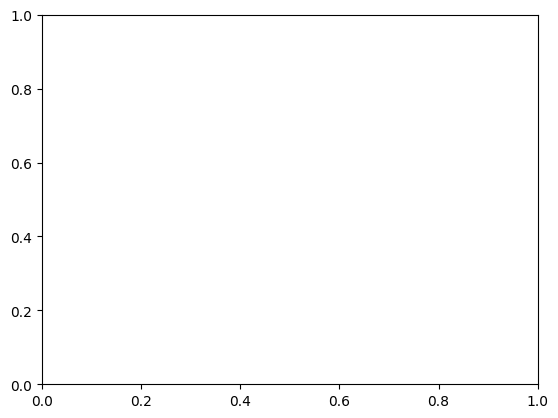

In [4]:
# Visualize actor losses
plt.plot(actor_losses)
plt.show()

In [ ]:
# Visualize critic losses
plt.plot(critic_losses)
plt.show()

In [ ]:
# Visualize rewards
plt.plot(rewards)
plt.show()